In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import seaborn as sns


mae = 'neg_mean_absolute_error'
mse = 'neg_mean_squared_error'
N_JOBS = 12
RANDOM_SEED = 42

# prepare models
models = {}

# models['LR'] = LinearRegression()
models['Ridge'] = Ridge()
models['PLS'] = PLSRegression()
models['DT'] = DecisionTreeRegressor(random_state=RANDOM_SEED)
models['Lasso'] = Lasso()
models['KNN'] = KNeighborsRegressor(n_jobs=N_JOBS)
models['SVR'] = SVR()
models['RF'] = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=N_JOBS)
models['XGB'] = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=N_JOBS, verbosity=0)

In [74]:
X_train = pd.read_csv('../data/processed/X_train.csv', index_col=0)
X_train.shape

(961, 2651)

In [75]:
y_train = pd.read_csv('../data/processed/y_train.csv', index_col=0).target
y_train.shape

(961,)

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

class OffsetScaler(BaseEstimator, TransformerMixin):
    """
    Applies StandardScaler the part of the input vector. Only values after offset are transformed [offset:],
    while keeping intact the initial part of vector [:offset].
    """
        
    def __init__(self, offset=0):
        self.offset = offset
        self.scaler = None

    def fit(self, X, y=None):
        self.scaler = StandardScaler().fit(X[:, self.offset:])
        return self
        

    def transform(self, X, y=None):
        x_fix = X[:, :self.offset]
        x_scale = self.scaler.transform(X[:, self.offset:])
        x_trans = np.hstack([x_fix, x_scale])
        return x_trans

In [77]:
def get_fps_offset(cols):
    res = []
    for c in cols:
        try:
            res.append(int(c))
        except:
            pass
    return len(res)

FPS_OFFSET = get_fps_offset(X_train.columns)

scaler = OffsetScaler(offset=FPS_OFFSET)

X_train_scale = scaler.fit_transform(X_train.values)

In [78]:
cv_res = cross_val_score(models['SVR'], X_train_scale, y_train, cv=10)
cv_res

array([ -17.17019044, -285.85129065, -378.83784063,  -75.65880516,
        -14.03156207,   -8.70846096,  -29.70682304,  -44.6444284 ,
       -244.75617679, -568.70747815])

In [79]:
results = {}

for name in models.keys():
    model = models[name]
    results[name] = cross_val_score(model, X_train_scale, y_train, cv=10)
    print("%5s: %.3f ± %.3f" % (name, results[name].mean(), results[name].std()))
    
results = pd.DataFrame(results)

Ridge: -269.605 ± 288.552
  PLS: -126.148 ± 117.273
   DT: -220.852 ± 266.568
Lasso: -111.108 ± 105.213
  KNN: -127.092 ± 119.907
  SVR: -166.807 ± 184.251
   RF: -82.639 ± 76.289
  XGB: -87.541 ± 87.263


<Axes: >

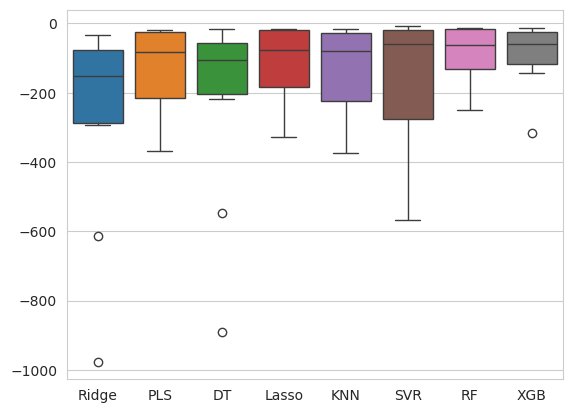

In [80]:
sns.boxplot(results)